<a href="https://colab.research.google.com/github/ASWINR341/pytorch_project/blob/main/image_classification_with_pretrained_googleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")
# 2b92da1fb9d499b2c3afb48d9da10858

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aswinr0341
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 887MB/s] 

In [5]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [7]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [8]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [9]:
#transform is for preprocessing, size and type
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform):
      self.dataframe = dataframe
      self.transform = transform
      self.labels = torch.tensor(dataframe["category"]).to(device)

  def __len__(self):
      return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)/255.0
    return image, label


In [11]:
train_dataset = CustomImageDataset(dataframe = train_df, transform = transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform = transform)

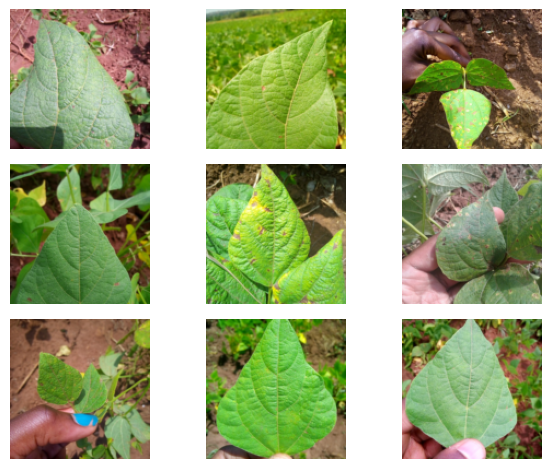

In [12]:
n_cols = n_rows = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    axarr[row, col].imshow((image*255.0).squeeze().permute(1,2,0))
    axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [13]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [14]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)


In [15]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 195MB/s]


In [16]:
for param in googlenet_model.parameters():
  param.requires_grad = True # allowing to param to learn again from already available weight


In [17]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [18]:
num_classes = len(train_df['category'].unique())
num_classes

3

In [19]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)

In [20]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0.0
    total_loss_train = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)   # Move inputs to GPU
        labels = labels.to(device)   # Move labels to GPU

        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
    total_loss_train_plot.append(round(total_loss_train/len(train_loader), 4))  # Better averaging

    print(f"EPOCH {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/len(train_loader), 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100,4)}")


EPOCH 1/15, Train Loss: 0.9403, Train Accuracy: 52.9981
EPOCH 2/15, Train Loss: 0.8824, Train Accuracy: 59.8646
EPOCH 3/15, Train Loss: 0.7714, Train Accuracy: 66.6344
EPOCH 4/15, Train Loss: 0.7236, Train Accuracy: 70.0193
EPOCH 5/15, Train Loss: 0.5976, Train Accuracy: 75.6286
EPOCH 6/15, Train Loss: 0.593, Train Accuracy: 77.3694
EPOCH 7/15, Train Loss: 0.5875, Train Accuracy: 76.499
EPOCH 8/15, Train Loss: 0.458, Train Accuracy: 81.4313
EPOCH 9/15, Train Loss: 0.528, Train Accuracy: 80.3675
EPOCH 10/15, Train Loss: 0.4828, Train Accuracy: 82.0116
EPOCH 11/15, Train Loss: 0.4695, Train Accuracy: 82.3017
EPOCH 12/15, Train Loss: 0.385, Train Accuracy: 87.1373
EPOCH 13/15, Train Loss: 0.4078, Train Accuracy: 84.6228
EPOCH 14/15, Train Loss: 0.394, Train Accuracy: 86.1702
EPOCH 15/15, Train Loss: 0.3258, Train Accuracy: 88.7814


In [30]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)   # Move inputs to GPU
    labels = labels.to(device)
    prediction = googlenet_model(inputs)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


In [31]:
print(round(total_acc_test/val_dataset.__len__()*100,4))

80.4511


In [37]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False

  googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
  googlenet_model.fc
  googlenet_model.to(device)

In [38]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0.0
    total_loss_train = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)   # Move inputs to GPU
        labels = labels.to(device)   # Move labels to GPU

        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
    total_loss_train_plot.append(round(total_loss_train/len(train_loader), 4))  # Better averaging

    print(f"EPOCH {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/len(train_loader), 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100,4)}")


EPOCH 1/15, Train Loss: 1.0208, Train Accuracy: 48.646
EPOCH 2/15, Train Loss: 0.9271, Train Accuracy: 56.9632
EPOCH 3/15, Train Loss: 0.9309, Train Accuracy: 55.1257
EPOCH 4/15, Train Loss: 0.8451, Train Accuracy: 61.8956
EPOCH 5/15, Train Loss: 0.8896, Train Accuracy: 60.5416
EPOCH 6/15, Train Loss: 0.8662, Train Accuracy: 61.5087
EPOCH 7/15, Train Loss: 0.8276, Train Accuracy: 63.5397
EPOCH 8/15, Train Loss: 0.8483, Train Accuracy: 61.412
EPOCH 9/15, Train Loss: 0.857, Train Accuracy: 62.766
EPOCH 10/15, Train Loss: 0.8183, Train Accuracy: 64.5068
EPOCH 11/15, Train Loss: 0.7836, Train Accuracy: 64.7002
EPOCH 12/15, Train Loss: 0.8306, Train Accuracy: 63.4429
EPOCH 13/15, Train Loss: 0.8679, Train Accuracy: 59.8646
EPOCH 14/15, Train Loss: 0.8996, Train Accuracy: 60.058
EPOCH 15/15, Train Loss: 0.8245, Train Accuracy: 64.6035


In [39]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)   # Move inputs to GPU
    labels = labels.to(device)
    prediction = googlenet_model(inputs)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


In [40]:
print(round(total_acc_test/val_dataset.__len__()*100,4))

60.9023
